In [ ]:
# ---- CELL 1: INSTALL PACKAGES ----
!pip install torch torchvision scikit-learn matplotlib transformers timm

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
# ---- CELL 2: IMPORT LIBRARIES & SET DEVICE ----
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from transformers import ViTModel, ViTFeatureExtractor
from sklearn.manifold import TSNE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
# ---- CELL 4: FEATURE EXTRACTION FUNCTION USING VIT ----
vit_model_name = "google/vit-base-patch16-224-in21k"
vit_model = ViTModel.from_pretrained(vit_model_name).to(device)
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

vit_model.eval()

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [ ]:
def extract_features(dataset, model, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_feats = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            imgs_resized = nn.functional.interpolate(imgs, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = model(imgs_resized)
            feats = outputs.pooler_output
            all_feats.append(feats.cpu().numpy())
    all_feats = np.concatenate(all_feats, axis=0)
    all_feats /= np.linalg.norm(all_feats, axis=1, keepdims=True)
    return all_feats

In [ ]:
# ---- CELL 5: TYPICLUST QUERY SELECTION ----
def select_queries(features, budget, n_clusters=None, k_neighbors=20):
    if n_clusters is None:
        n_clusters = budget
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(features)
    query_indices = []
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        cluster_feats = features[mask]
        if len(cluster_feats) < 5:
            continue
        nbrs = NearestNeighbors(n_neighbors=min(k_neighbors, len(cluster_feats))).fit(cluster_feats)
        dists, _ = nbrs.kneighbors(cluster_feats)
        typicality = 1.0 / (np.mean(dists**2, axis=1) + 1e-8)
        idx = np.argmax(typicality)
        global_idx = np.where(mask)[0][idx]
        query_indices.append(global_idx)
    return query_indices[:budget]

def select_queries_random(unlabeled_indices, budget):
    return np.random.choice(unlabeled_indices, size=budget, replace=False).tolist()

In [ ]:
# ---- CELL 6: INITIAL QUERY SELECTION ----
budget_per_round = 50
features = extract_features(train_dataset, vit_model)
initial_queries = select_queries(features, budget_per_round, n_clusters=budget_per_round)

In [ ]:
# ---- CELL 7: EVALUATION FUNCTIONS (FS, LIN, SSL) ----
def evaluate_fs(indices, train_dataset, test_loader, epochs=50, batch_size=50):
    subset = Subset(train_dataset, indices)
    loader = DataLoader(subset, batch_size=50, shuffle=True)
    model = models.resnet18(weights='IMAGENET1K_V1').to(device)
    model.fc = nn.Linear(model.fc.in_features, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(5):
        for inputs, labels in loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total * 100
    return accuracy
    print(f"FS Accuracy: {correct/len(test_dataset)*100:.2f}%")


--- FS Evaluation Round 1 ---
Round 1, FS accuracy: 23.26%

--- FS Evaluation Round 2 ---
Round 2, FS accuracy: 26.59%

--- FS Evaluation Round 3 ---
Round 3, FS accuracy: 32.85%

--- FS Evaluation Round 4 ---
Round 4, FS accuracy: 38.64%

--- FS Evaluation Round 5 ---
Round 5, FS accuracy: 41.93%


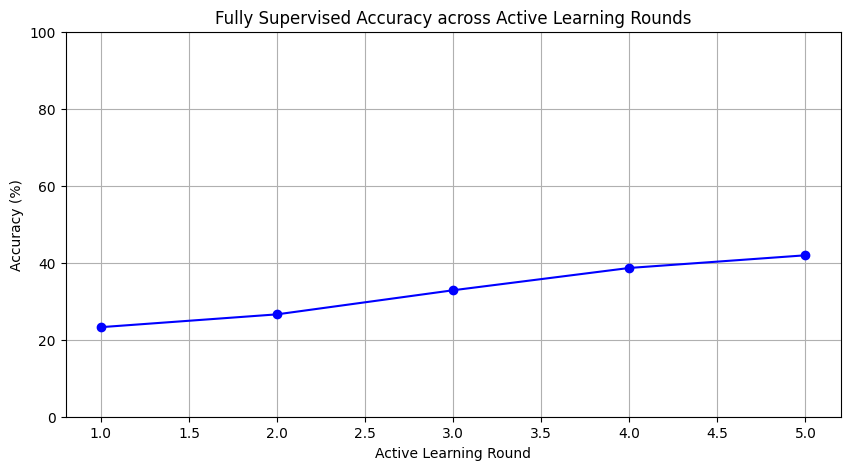

In [ ]:
# Fully Supervised Evaluation (5 AL rounds)
num_rounds = 5
budget_per_round = 50

all_indices = set(range(len(train_dataset)))
selected_indices_fs = set()

fs_accuracies = []

features = extract_features(train_dataset, vit_model)

for round in range(1, num_rounds + 1):
    print(f"\n--- FS Evaluation Round {round} ---")

    # Select new queries
    remaining_indices = list(all_indices - selected_indices_fs)
    new_selected = select_queries(features[remaining_indices], budget_per_round)
    selected_indices_fs.update([remaining_indices[idx] for idx in new_selected])

    # Evaluate FS
    fs_acc = evaluate_fs(list(selected_indices_fs), train_dataset, test_loader)
    print(f"Round {round}, FS accuracy: {fs_acc:.2f}%")
    fs_accuracies.append(fs_acc)

# Plot FS Results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_rounds + 1), fs_accuracies, marker='o', color='blue')
plt.xlabel('Active Learning Round')
plt.ylabel('Accuracy (%)')
plt.title('Fully Supervised Accuracy across Active Learning Rounds')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

In [ ]:
def evaluate_lin(indices, train_dataset, test_dataset, vit_model):
    X_train = extract_features(Subset(train_dataset, indices), vit_model)
    y_train = [train_dataset[i][1] for i in indices]

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

    X_test = extract_features(test_dataset, vit_model)
    y_test = [label for _, label in test_dataset]

    acc = clf.score(X_test, y_test)
    print(f"Linear Accuracy: {acc*100:.2f}%")

    return acc * 100  # <-- Explicitly returning accuracy percentage


--- LIN Evaluation Round 1 ---
Linear Accuracy: 71.56%
Round 1, LIN accuracy: 71.56%

--- LIN Evaluation Round 2 ---
Linear Accuracy: 80.94%
Round 2, LIN accuracy: 80.94%

--- LIN Evaluation Round 3 ---
Linear Accuracy: 87.52%
Round 3, LIN accuracy: 87.52%

--- LIN Evaluation Round 4 ---
Linear Accuracy: 87.78%
Round 4, LIN accuracy: 87.78%

--- LIN Evaluation Round 5 ---
Linear Accuracy: 88.81%
Round 5, LIN accuracy: 88.81%


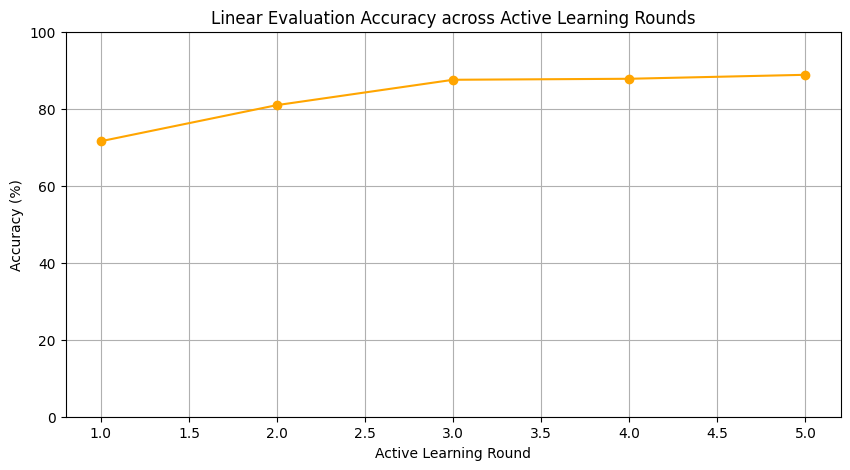

In [ ]:
# Parameters
num_rounds = 5
budget_per_round = 50

# Initializations
all_indices = set(range(len(train_dataset)))
selected_indices_lin = set()

lin_accuracies = []

# Extract initial features for the whole dataset (to save time)
features = extract_features(train_dataset, vit_model)

for round in range(1, num_rounds + 1):
    print(f"\n--- LIN Evaluation Round {round} ---")

    # Select new queries
    remaining_indices = list(all_indices - selected_indices_lin)
    new_selected = select_queries(features[remaining_indices], budget_per_round)
    selected_indices_lin.update([remaining_indices[idx] for idx in new_selected])

    # Evaluate current labeled set
    lin_acc = evaluate_lin(
        list(selected_indices_lin), train_dataset, test_dataset, vit_model
    )
    print(f"Round {round}, LIN accuracy: {lin_acc:.2f}%")
    lin_accuracies.append(lin_acc)

# Plot Linear Evaluation Results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_rounds + 1), lin_accuracies, marker='o', color='orange')
plt.xlabel('Active Learning Round')
plt.ylabel('Accuracy (%)')
plt.title('Linear Evaluation Accuracy across Active Learning Rounds')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

In [ ]:
def evaluate_ssl(labeled_indices, train_dataset, test_loader, epochs=50, threshold=0.95, batch_size=64):
    labeled_subset = Subset(train_dataset, list(labeled_indices))
    labeled_loader = DataLoader(labeled_subset, batch_size=batch_size, shuffle=True)

    unlabeled_indices = list(set(range(len(train_dataset))) - set(labeled_indices))
    unlabeled_subset = Subset(train_dataset, unlabeled_indices)
    unlabeled_loader = DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=True)

    class SemiSupervisedCNN(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
            )
            self.classifier = nn.Sequential(
                nn.Linear(64*8*8, 128), nn.ReLU(), nn.Linear(128, num_classes)
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            return self.classifier(x)

    model = SemiSupervisedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=5e-4)

    for epoch in range(epochs):
        model.train()
        for (x_labeled, y_labeled), (x_unlabeled, _) in zip(labeled_loader, unlabeled_loader):
            x_labeled, y_labeled = x_labeled.to(device), y_labeled.to(device)
            x_unlabeled = x_unlabeled.to(device)

            # Supervised loss
            preds_labeled = model(x_labeled)
            loss_sup = criterion(preds_labeled, y_labeled)

            # Unsupervised pseudo-labeling
            with torch.no_grad():
                preds_unlabeled = model(x_unlabeled)
                probs_unlabeled = torch.softmax(preds_unlabeled, dim=1)
                confidence, pseudo_labels = probs_unlabeled.max(dim=1)
                mask = confidence > threshold

            if mask.sum() > 0:
                preds_selected = model(x_unlabeled[mask])
                loss_unsup = criterion(preds_selected, pseudo_labels[mask])
            else:
                loss_unsup = torch.tensor(0.0).to(device)

            total_loss = loss_sup + loss_unsup

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            preds = model(x_test).argmax(dim=1)
            correct += (preds == y_test).sum().item()
            total += y_test.size(0)

    accuracy = 100 * correct / total
    print(f"🔍 SSL accuracy: {accuracy:.2f}%")
    return accuracy


--- SSL Evaluation Round 1 ---
🔍 SSL accuracy: 22.03%
Round 1, SSL accuracy: 22.03%

--- SSL Evaluation Round 2 ---
🔍 SSL accuracy: 24.03%
Round 2, SSL accuracy: 24.03%

--- SSL Evaluation Round 3 ---
🔍 SSL accuracy: 27.07%
Round 3, SSL accuracy: 27.07%

--- SSL Evaluation Round 4 ---
🔍 SSL accuracy: 28.06%
Round 4, SSL accuracy: 28.06%

--- SSL Evaluation Round 5 ---
🔍 SSL accuracy: 32.08%
Round 5, SSL accuracy: 32.08%


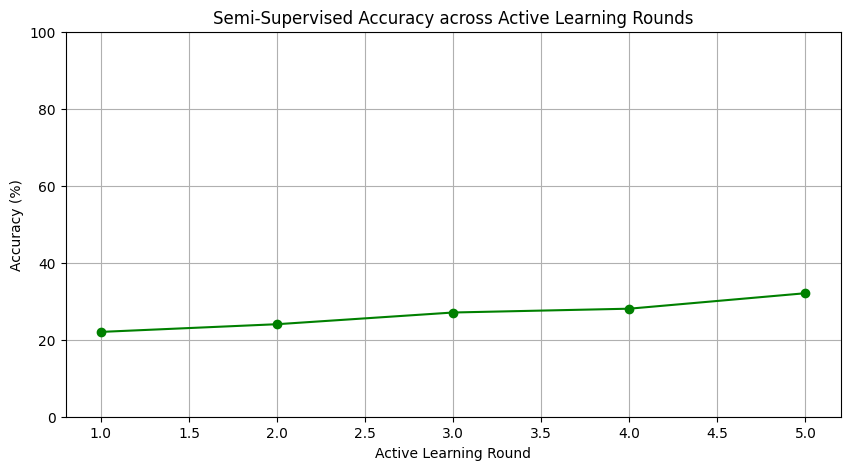

In [ ]:
# Semi-Supervised Evaluation (5 AL rounds)
num_rounds = 5
budget_per_round = 50

all_indices = set(range(len(train_dataset)))
selected_indices_ssl = set()

ssl_accuracies = []

features = extract_features(train_dataset, vit_model)

for round in range(1, num_rounds + 1):
    print(f"\n--- SSL Evaluation Round {round} ---")

    # Select new queries
    remaining_indices = list(all_indices - selected_indices_ssl)
    new_selected = select_queries(features[remaining_indices], budget_per_round)
    selected_indices_ssl.update([remaining_indices[idx] for idx in new_selected])

    # Evaluate SSL
    ssl_acc = evaluate_ssl(list(selected_indices_ssl), train_dataset, test_loader)
    print(f"Round {round}, SSL accuracy: {ssl_acc:.2f}%")
    ssl_accuracies.append(ssl_acc)

# Plot SSL Results
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_rounds + 1), ssl_accuracies, marker='o', color='green')
plt.xlabel('Active Learning Round')
plt.ylabel('Accuracy (%)')
plt.title('Semi-Supervised Accuracy across Active Learning Rounds')
plt.ylim(0, 100)
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


🔍 Linear classifier accuracy: 93.05%


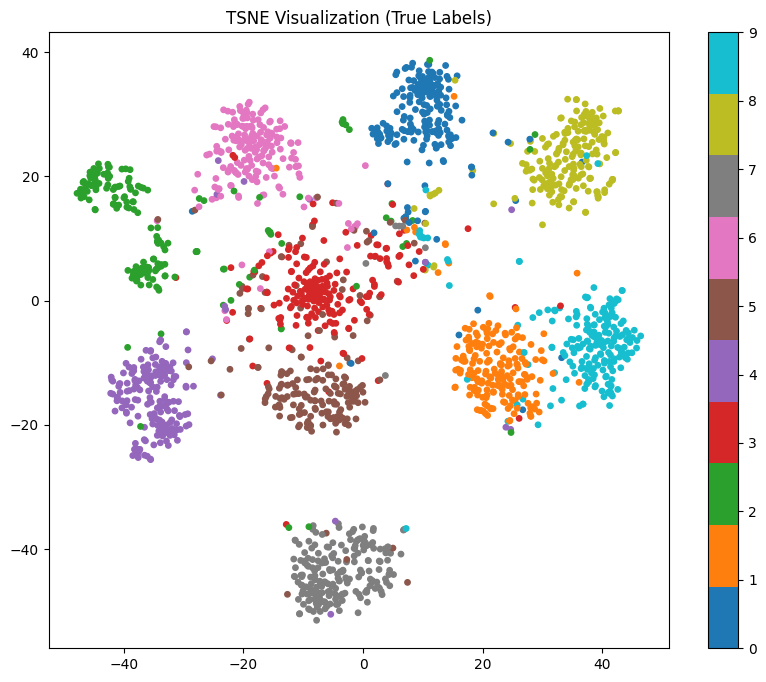

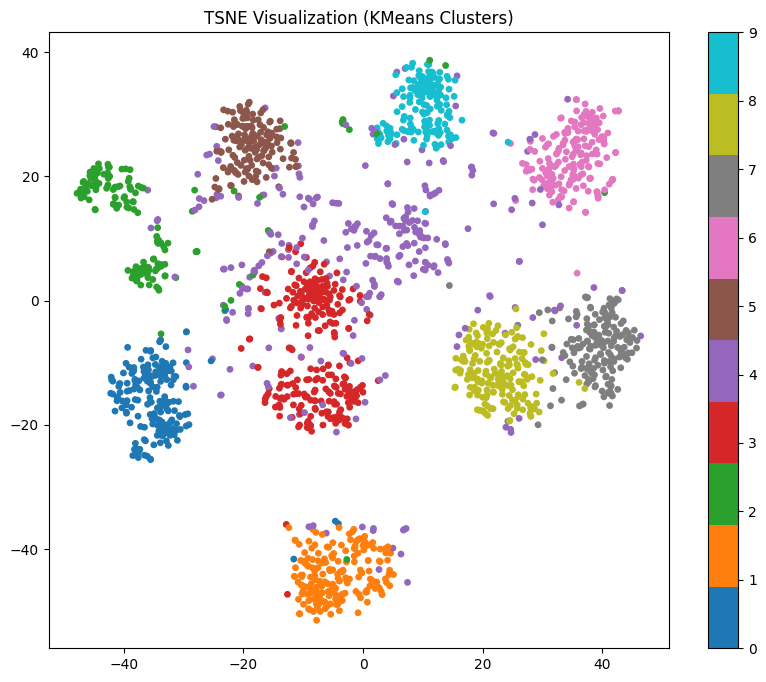

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA  # Add this line
from sklearn.cluster import KMeans

def linear_probe(embeddings, labels):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42, stratify=labels
    )
    clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(f"🔍 Linear classifier accuracy: {acc*100:.2f}%")
    return acc

def visualize_embedding_clusters(embeddings, labels, method='tsne', sample_size=2000, n_clusters=10):
    indices = np.random.choice(len(embeddings), sample_size, replace=False)
    reducer = TSNE(n_components=2, random_state=42) if method == 'tsne' else PCA(n_components=2)
    reduced_embs = reducer.fit_transform(embeddings[indices])

    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=np.array(labels)[indices], cmap='tab10', s=15)
    plt.title(f"{method.upper()} Visualization (True Labels)")
    plt.colorbar()
    plt.show()

    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(embeddings[indices])
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embs[:, 0], reduced_embs[:, 1], c=kmeans.labels_, cmap='tab10', s=15)
    plt.title(f"{method.upper()} Visualization (KMeans Clusters)")
    plt.colorbar()
    plt.show()

embeddings = extract_features(train_dataset, vit_model, batch_size=128)
labels = [label for _, label in train_dataset]

linear_probe(embeddings, labels)
visualize_embedding_clusters(embeddings, labels, 'tsne')